LightGBM Model

Importing Libraries

In [2]:
import lightgbm as lgb
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc,matthews_corrcoef,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.metrics import mean_squared_error
import time 


In [9]:
file_path = "../../../data/processed/train_data.csv"
df = pd.read_csv(file_path)
file_path2= "../../../data/processed/test_data.csv"
df2 = pd.read_csv(file_path2)

Model Functions

In [3]:

# application du binning for the features to reduce the number of splits
def apply_binning(X, num_bins=256):
    binned_data = np.zeros_like(X)
    #list to store the bin edges for each feature
    bin_edges_list = []
    
    for i in range(X.shape[1]):
        col = X[:, i]
        #min and max values of the feature for sorting the values before binning
        bins = np.linspace(col.min(), col.max(), num_bins + 1)
        #digitize function to bin the values and subtract 1 to start the bin index from 0
        binned_data[:, i] = np.digitize(col, bins) - 1
        bin_edges_list.append(bins)
    
    return binned_data, bin_edges_list

# function to initialize the predictions with the log_odds for avoiding the overflow with the values of 0 and 1
def initialize_predictions(y):
    p = np.mean(y)
    log_odds = np.log(p / (1 - p))
    return np.full_like(y, 1 / (1 + np.exp(-log_odds)), dtype=np.float32)

# function to compute the residuals and hessians for the gradient boosting
def compute_residuals_and_hessians(y_true, y_pred):
    residuals = y_pred - y_true
    #hessians for calculating the second order derivative for knowing the curvature of the loss function
    hessians = y_pred * (1 - y_pred)
    return residuals, hessians

# function to update the predictions after finding the best split
def update_predictions(X, best_feature, best_split, gradients, hessians, learning_rate):
    predictions_update = np.zeros_like(gradients)
    #mask for the samples in the left node
    
    left_mask = X[:, best_feature] < best_split
    #mask for the samples in the right node
    right_mask = ~left_mask
    #calculating the gradients and hessians for the left and right nodes
    left_grad = gradients[left_mask].sum()
    left_hess = hessians[left_mask].sum()
    right_grad = gradients[right_mask].sum()
    right_hess = hessians[right_mask].sum()
    
    if left_hess > 0:
        left_value = -left_grad / left_hess
    else:
        left_value = 0
    
    if right_hess > 0:
        right_value = -right_grad / right_hess
    else:
        right_value = 0
    
    predictions_update[left_mask] = left_value
    predictions_update[right_mask] = right_value
    
    return predictions_update * learning_rate

def find_best_split(X, gradients, hessians, num_bins):
    # Initialize with negative infinity for assurring taht the first gain will be higher
    best_gain = -np.inf
    best_feature, best_split = None, None

    for feature in range(X.shape[1]): 
        bin_gradients = np.zeros(num_bins)
        bin_hessians = np.zeros(num_bins)
        #calculating the gradients and hessians for each bin 
        for bin_idx in range(num_bins):
            #mask for the samples in the bin 
            mask = (X[:, feature] == bin_idx)  
            #summing the gradients and hessians for the samples in the bin for assruing that the bin is not empty
            bin_gradients[bin_idx] = gradients[mask].sum()
            bin_hessians[bin_idx] = hessians[mask].sum()
        #searching for the best split
        for split in range(1, num_bins):
            #calculating the gain for the split for left and right nodes because the gain is the sum of the gains of the left and right nodes
            left_grad = bin_gradients[:split].sum()
            left_hess = bin_hessians[:split].sum()
            right_grad = bin_gradients[split:].sum()
            right_hess = bin_hessians[split:].sum()
            #if the hessians are positive we can calculate the gain
            if left_hess > 0 and right_hess > 0:
                gain = (left_grad ** 2 / left_hess) + (right_grad ** 2 / right_hess)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = split

    return best_feature, best_split, best_gain
# function to train the lightgbm model
def train_lightgbm(X, y, num_bins=64, learning_rate=1.2, num_trees=10):
    start=time.time()
    X_binned, bin_edges = apply_binning(X, num_bins=num_bins)
    
    initial_prediction = np.log(y.mean() / (1 - y.mean()))
    y_pred = np.full_like(y, initial_prediction, dtype=float)
    
    trees = []
    
    for tree in range(num_trees):
        gradients, hessians = compute_residuals_and_hessians(y, 1 / (1 + np.exp(-y_pred)))
        
        best_feature, best_split, best_gain = find_best_split(X_binned, gradients, hessians, num_bins)
        predictions_update = update_predictions(X_binned, best_feature, best_split, gradients, hessians, learning_rate)
        y_pred += predictions_update
        
        tree_structure = {
            'feature': best_feature,
            'split': best_split,
            'left_value': -gradients[X_binned[:, best_feature] < best_split].sum() / hessians[X_binned[:, best_feature] < best_split].sum(),
            'right_value': -gradients[X_binned[:, best_feature] >= best_split].sum() / hessians[X_binned[:, best_feature] >= best_split].sum(),
        }
        trees.append(tree_structure)
    end = time.time()  
    print(f"Training Time: {end - start:.4f} seconds")
    return trees, initial_prediction


def predict_lightgbm(X, trees, initial_prediction, num_bins=64):
    start=time.time()
    X_binned, _ = apply_binning(X, num_bins=num_bins)
    y_pred = np.full(X.shape[0], initial_prediction, dtype=float)
    
    for tree in trees:
        feature = tree['feature']
        split = tree['split']
        left_value = tree['left_value']
        right_value = tree['right_value']
        
        mask = X_binned[:, feature] < split
        y_pred[mask] += left_value
        y_pred[~mask] += right_value
    end = time.time()  # End timer
    print(f"Testing Time: {end - start:.4f} seconds")
    return expit(y_pred)


Implemented the lightgbm model with the training and prediction functions and applied it to the train and test data

Training model without Features selection

In [11]:

X_train= df.drop(columns=['target']).values
y_train= df['target'].values
X_test= df2.drop(columns=['target']).values
y_test= df2['target'].values
num_bins = 70
learning_rate = 0.1
num_trees = 300
start_train_without_fs = time.time()
trained_trees_without_fs, initial_prediction_without_fs = train_lightgbm(
    X_train, y_train, num_bins=70, learning_rate=0.1, num_trees=300
)
end_train_without_fs = time.time()
training_time_without_fs = end_train_without_fs - start_train_without_fs

start_test_without_fs = time.time()
y_pred_test_without_fs = predict_lightgbm(X_test, trained_trees_without_fs, initial_prediction_without_fs, num_bins=70)
end_test_without_fs = time.time()
testing_time_without_fs = end_test_without_fs - start_test_without_fs
y_pred_test_without_fs = (y_pred_test_without_fs >= 0.5).astype(int)

accuracy= accuracy_score(y_test, y_pred_test_without_fs)


print(f"Accuracy sur le jeu de test : {accuracy * 100:.2f}%")

Training Time: 339.5780 seconds
Testing Time: 0.0522 seconds
Accuracy sur le jeu de test : 82.27%


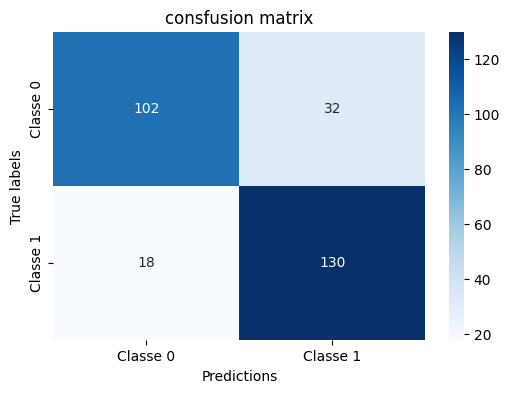

In [12]:
conf_matrix = confusion_matrix(y_test, (y_pred_test_without_fs >= 0.5).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("consfusion matrix")
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.show()


In [13]:
mse = mean_squared_error(y_test, y_pred_test_without_fs)
print(f"Erreur Quadratique Moyenne (MSE) : {mse:.4f}")

Erreur Quadratique Moyenne (MSE) : 0.1773


In [14]:
class_report = classification_report(y_test, (y_pred_test_without_fs >= 0.5).astype(int))
print("Rapport de Classification :")
print(class_report)

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       134
           1       0.80      0.88      0.84       148

    accuracy                           0.82       282
   macro avg       0.83      0.82      0.82       282
weighted avg       0.83      0.82      0.82       282



AUC : 81.98%
MCC : 0.65


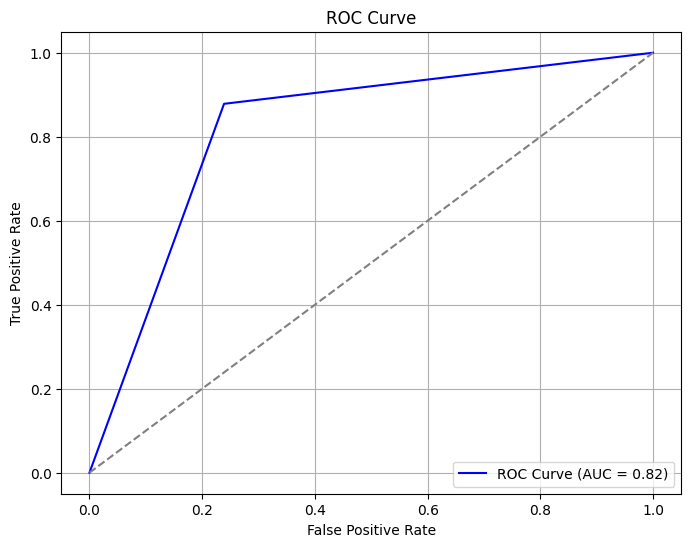

In [15]:

y_prob = y_pred_test_without_fs 
y_pred = (y_pred_test_without_fs >= 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test, y_prob)  
roc_auc = auc(fpr, tpr)                           

# Calcul MCC
mcc = matthews_corrcoef(y_test, y_pred)

print(f"AUC : {roc_auc:.2%}")
print(f"MCC : {mcc:.2f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [6]:
df1= pd.read_csv("../../../data/processed/train_filtered.csv")
df_test=pd.read_csv("../../../data/processed/test_filtered.csv")
X_train= df1.drop(columns=['target']).values
y_train= df1['target'].values
X_test1= df_test.drop(columns=['target']).values
y_test1= df_test['target'].values
num_bins = 70
learning_rate = 0.05
num_trees = 300

start_train_with_fs = time.time()
trained_trees_with_fs, initial_prediction_with_fs = train_lightgbm(
    X_train, y_train, num_bins=70, learning_rate=0.1, num_trees=300
)
end_train_with_fs = time.time()
training_time_with_fs = end_train_with_fs - start_train_with_fs

start_test_with_fs = time.time()
y_pred_test_with_fs = predict_lightgbm(X_test1, trained_trees_with_fs, initial_prediction_with_fs, num_bins=70)
end_test_with_fs = time.time()
testing_time_with_fs = end_test_with_fs - start_test_with_fs
y_pred_test_with_fs = (y_pred_test_with_fs >= 0.5).astype(int)

accuracy= accuracy_score(y_test1, y_pred_test_with_fs)


print(f"Accuracy sur le jeu de test : {accuracy * 100:.2f}%")

Training Time: 28.8781 seconds
Testing Time: 0.0156 seconds
Accuracy sur le jeu de test : 89.36%


In [17]:
mse = mean_squared_error(y_test1, y_pred_test_with_fs)
print(f"Erreur Quadratique Moyenne (MSE) : {mse:.4f}")

Erreur Quadratique Moyenne (MSE) : 0.1064


In [18]:
class_report = classification_report(y_test, (y_pred_test_with_fs >= 0.5).astype(int))
print("Rapport de Classification :")
print(class_report)

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       134
           1       0.90      0.89      0.90       148

    accuracy                           0.89       282
   macro avg       0.89      0.89      0.89       282
weighted avg       0.89      0.89      0.89       282



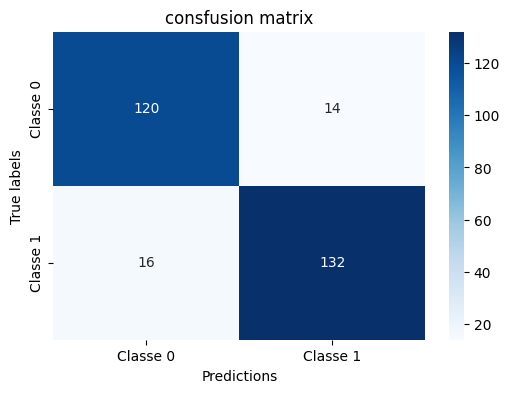

In [19]:
conf_matrix = confusion_matrix(y_test1, (y_pred_test_with_fs >= 0.5).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("consfusion matrix")
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.show()


AUC : 89.37%
MCC : 0.79


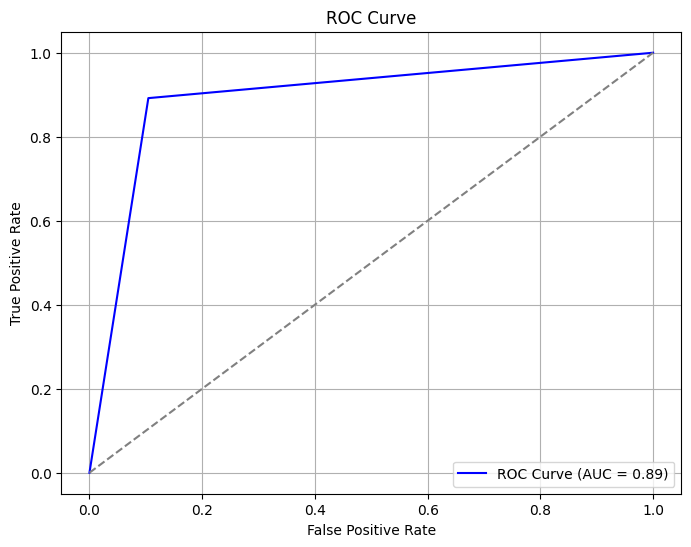

In [20]:

y_prob = y_pred_test_with_fs  
y_pred = (y_pred_test_with_fs >= 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test1, y_prob)  # ROC
roc_auc = auc(fpr, tpr)                           # AUC

# Calcul MCC
mcc = matthews_corrcoef(y_test1, y_pred)

print(f"AUC : {roc_auc:.2%}")
print(f"MCC : {mcc:.2f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


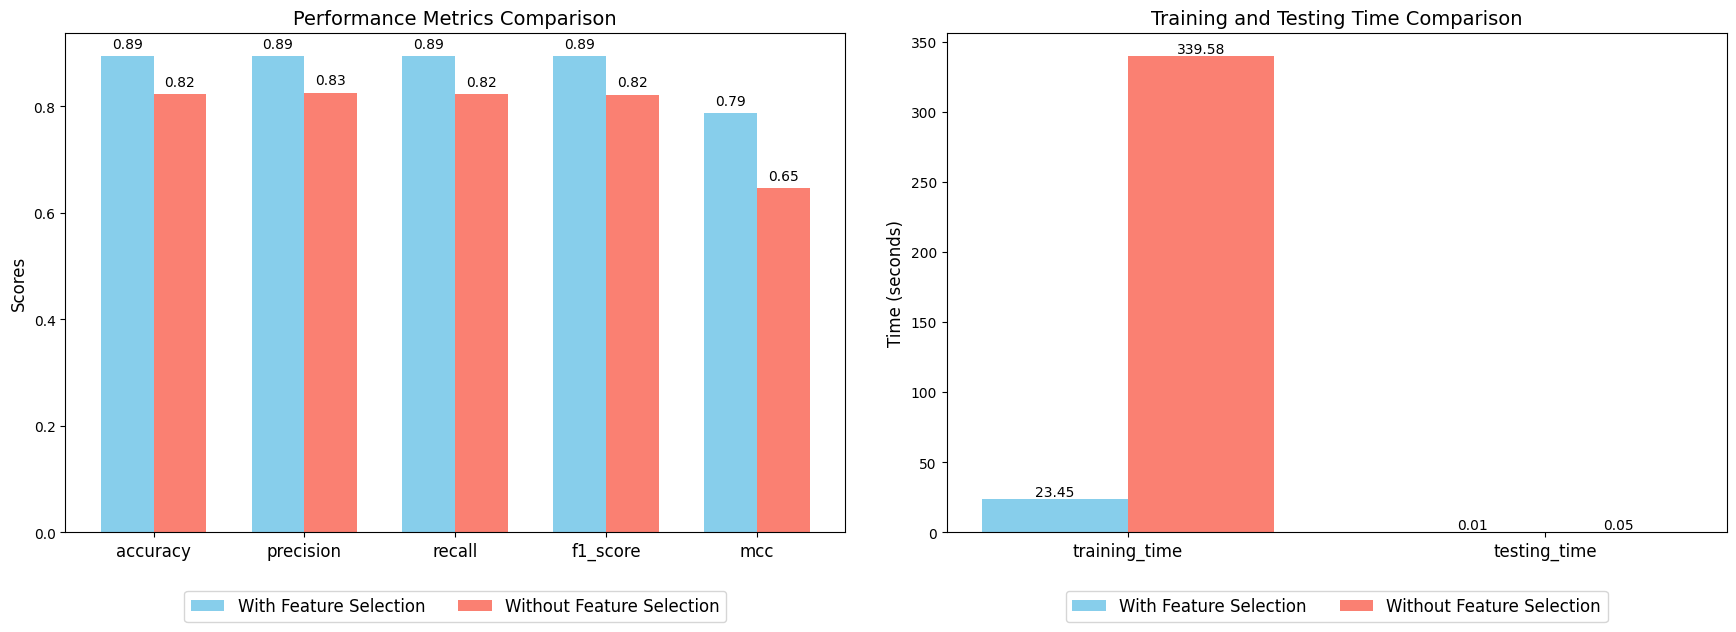

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, matthews_corrcoef
)

# Compute performance metrics
# ========================
# With Feature Selection
class_report_with_fs = classification_report(y_test, y_pred_test_with_fs, output_dict=True)

metrics_with_fs = {
    "accuracy": accuracy_score(y_test, y_pred_test_with_fs),
    "precision": class_report_with_fs["weighted avg"]["precision"],
    "recall": class_report_with_fs["weighted avg"]["recall"],
    "f1_score": class_report_with_fs["weighted avg"]["f1-score"],
    "mcc": matthews_corrcoef(y_test, y_pred_test_with_fs),
    "training_time": training_time_with_fs,
    "testing_time": testing_time_with_fs,
}

# Without Feature Selection
class_report_without_fs = classification_report(y_test, y_pred_test_without_fs, output_dict=True)
metrics_without_fs = {
    "accuracy": accuracy_score(y_test, y_pred_test_without_fs),
    "precision": class_report_without_fs["weighted avg"]["precision"],
    "recall": class_report_without_fs["weighted avg"]["recall"],
    "f1_score": class_report_without_fs["weighted avg"]["f1-score"],
    "mcc": matthews_corrcoef(y_test, y_pred_test_without_fs),
    "training_time": training_time_without_fs,
    "testing_time": testing_time_without_fs,
}

# ========================
# Plotting the comparison
# ========================
performance_metrics = ["accuracy", "precision", "recall", "f1_score", "mcc"]
time_metrics = ["training_time", "testing_time"]

with_fs_performance = [metrics_with_fs[m] for m in performance_metrics]
without_fs_performance = [metrics_without_fs[m] for m in performance_metrics]

with_fs_time = [metrics_with_fs[m] for m in time_metrics]
without_fs_time = [metrics_without_fs[m] for m in time_metrics]

# Set up the bar chart parameters
x_perf = np.arange(len(performance_metrics))
x_time = np.arange(len(time_metrics))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ========================
# Performance Metrics Plot
# ========================
rects1 = ax1.bar(x_perf - width / 2, with_fs_performance, width, label="With Feature Selection", color="skyblue")
rects2 = ax1.bar(x_perf + width / 2, without_fs_performance, width, label="Without Feature Selection", color="salmon")

ax1.set_ylabel("Scores", fontsize=12)
ax1.set_title("Performance Metrics Comparison", fontsize=14)
ax1.set_xticks(x_perf)
ax1.set_xticklabels(performance_metrics, fontsize=12)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

# Add values to bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2.0,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# ========================
# Time Metrics Plot
# ========================
rects3 = ax2.bar(x_time - width / 2, with_fs_time, width, label="With Feature Selection", color="skyblue")
rects4 = ax2.bar(x_time + width / 2, without_fs_time, width, label="Without Feature Selection", color="salmon")

ax2.set_ylabel("Time (seconds)", fontsize=12)
ax2.set_title("Training and Testing Time Comparison", fontsize=14)
ax2.set_xticks(x_time)
ax2.set_xticklabels(time_metrics, fontsize=12)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

# Add values to bars
for rect in rects3 + rects4:
    height = rect.get_height()
    ax2.text(
        rect.get_x() + rect.get_width() / 2.0,
        height ,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

fig.tight_layout(pad=3)
plt.show()
